## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

In [1]:
# set up environment
!pip install pytorchcv

# download
!gdown --id '1B9eZQfwsFI6lWVN8mlLd-4CIwvEE7ZBv' -O data.zip

# unzip
!unzip ./data.zip
!rm ./data.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 6.7 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1B9eZQfwsFI6lWVN8mlLd-4CIwvEE7ZBv
To: /content/data.zip
100% 572k/572k [00:00<00:00, 5.75MB/s]
Archive:  ./data.zip
   creating: data/
  inflating: __MACOSX/._data         
   creating: data/cat/
  inflating: __MACOSX/data/._cat     
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/dog/
  inflating: __MACOSX/data/._dog     
   creating: data/truck/
  inflating: __MACOSX/data/._truck   
   creating: data/bird/
  inflating: __MACOSX/data/._bird    
   creating: data/airplane/
  inflating: __MACOSX/data/._airplane  
   creating: data/ship/
  inflating: __MACOSX/data/._ship    
   creating: data/fro

## Global Settings

* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [2]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8

# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std
# TODO: iterative fgsm attack
# alpha (step size) can be decided by yourself
alpha = 0.8/255/std

root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [3]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


## Utils -- Benign Images Evaluation

In [4]:
# to evaluate the performance of model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

## Utils -- Attack Algorithm

In [5]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    x_adv = x_adv + epsilon * x_adv.grad.detach().sign()
    return x_adv

# TODO: perform iterative fgsm attack
# set alpha as the step size in Global Settings section
# alpha and num_iter can be decided by yourself
# def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=20):
#     # initialize x_adv as original benign image x
#     # write a loop of num_iter to represent the iterative times
#     # for each loop
#         # call fgsm with (epsilon = alpha) to obtain new x_adv
#         # clip new x_adv back to [x-epsilon, x+epsilon]
#     # return x_adv
#     pass

def ifgsm(model, x, y, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=200):
    x_adv = x.detach().clone()  # initialize x_adv as original benign image x
    for _ in range(num_iter):
        # call fgsm with (epsilon = alpha) to obtain new x_adv
        x_adv = fgsm(model, x_adv, y, loss_fn, epsilon=alpha)
        # clip new x_adv back to [x-epsilon, x+epsilon]
        x_adv = torch.min(torch.max(x_adv, x - epsilon), x + epsilon).detach_()
    return x_adv

## Utils -- Attack

* Recall
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.

* Inverse function
    * Inverse Normalize() can be seen as a function where $N^{-1}(x) = x*std+mean$ where $mean$ and $std$ are constants.
    * Inverse ToTensor() can be seen as a function where $T^{-1}(x) = x*255$.

* Special Noted
    * ToTensor() will also convert the image from shape (height, width, channel) to shape (channel, height, width), so we also need to transpose the shape back to original shape.
    * Since our dataloader samples a batch of data, what we need here is to transpose **(batch_size, channel, height, width)** back to **(batch_size, height, width, channel)** using np.transpose.

In [6]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, ifgsm, loss_fn)
# print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

In [7]:
# from pytorchcv.model_provider import get_model as ptcv_get_model

# model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
# loss_fn = nn.CrossEntropyLoss()

# benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)
# print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

benign_acc = 0.95000, benign_loss = 0.22678


In [10]:
import torch
import torch.nn as nn
from pytorchcv.model_provider import get_model as ptcv_get_model

# Assume you have a DataLoader named adv_loader for your adversarial examples

# List of SOTA models for CIFAR-10
model_names = ['resnet110_cifar10', 'seresnet110_cifar10', 'resnext29_16x64d_cifar10']


# Initialize lists to store accuracies and losses
benign_acc_list = []
benign_loss_list = []

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Iterate over each SOTA model
for model_name in model_names:
    # Load the pretrained model
    model = ptcv_get_model(model_name, pretrained=True).to(device)
    loss_fn = nn.CrossEntropyLoss()

    # Example function epoch_benign is assumed to be defined
    benign_acc, benign_loss = epoch_benign(model, adv_loader, loss_fn)

    # Store the results
    benign_acc_list.append(benign_acc)
    benign_loss_list.append(benign_loss)

    print(f'{model_name}: benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

# Calculate the final score based on the average accuracy or any other desired metric
final_score = sum(benign_acc_list) / len(benign_acc_list)
print(f"Final Score (Average Benign Accuracy): {final_score:.5f}")


resnet110_cifar10: benign_acc = 0.95000, benign_loss = 0.22678
seresnet110_cifar10: benign_acc = 0.95500, benign_loss = 0.27532
resnext29_16x64d_cifar10: benign_acc = 0.95000, benign_loss = 0.25942
resnext29_16x64d_cifar10: benign_acc = 0.95000, benign_loss = 0.25942
Final Score (Average Benign Accuracy): 0.95125



## FGSM

In [ ]:
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples, adv_names)

## I-FGSM

In [9]:
# TODO: iterative fgsm attack
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, ifgsm, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsm', adv_examples, adv_names)

ifgsm_acc = 0.00000, ifgsm_loss = 25.81118


In [ ]:
# !pip install timm


In [14]:
# from models.resnet_cifar import ResNet34
# from models.nin_cifar import NiN
# from models.preresnet_cifar import PreResNet110
# from models.resnext_cifar import ResNeXt29_8x64d
# from models.seresnet_cifar import SEResNet18
# from models.sepreresnet_cifar import SEPreResNet18
# from models.pyramidnet_cifar import PyramidNet110_270
# from models.densenet_cifar import DenseNet121
# from models.xdensenet_cifar import XDenseNetBC_100_12
# from models.wrn_cifar import WideResNet28_10
# from models.wrn1bit_cifar import WRN1bit16x4
# from models.ror_cifar import RoR3
# from models.rir_cifar import ResNet_56_RIR

# # Choose a mix of models from different architectures
# model_nin = NiN()
# model_resnet = ResNet34()
# model_preresnet = PreResNet110()
# model_resnext = ResNeXt29_8x64d()
# model_seresnet = SEResNet18()
# model_sepreresnet = SEPreResNet18()
# model_pyramidnet = PyramidNet110_270()
# model_densenet = DenseNet121()
# model_xdensenet = XDenseNetBC_100_12()
# model_wrn = WideResNet28_10()
# model_wrn1bit = WRN1bit16x4()
# model_ror = RoR3()
# model_rir = ResNet_56_RIR()

# # Add these models to a list to form an ensemble
# ensemble_models = [model_nin, model_resnet, model_preresnet, model_resnext, model_seresnet,
#                    model_sepreresnet, model_pyramidnet, model_densenet, model_xdensenet,
#                    model_wrn, model_wrn1bit, model_ror, model_rir]

# # Ensure the models are in evaluation mode
# for model in ensemble_models:
#     model.eval()

ModuleNotFoundError: ignored

In [35]:

# # Define the iFGSM attack function for a single step
# def ifgsm_attack(model, x, y, loss_fn, epsilon=epsilon, alpha=epsilon / 10, num_iter=20):
#     x_adv = x.detach().clone()  # Initialize x_adv as original benign image x
#     x_adv.requires_grad = True  # Need to obtain gradient of x_adv, thus set required grad

#     for _ in range(num_iter):
#         # Call FGSM with (epsilon = alpha) to obtain new x_adv
#         x_adv = fgsm_attack(model, x_adv, y, loss_fn, epsilon=alpha)
#         # Clip new x_adv back to [x-epsilon, x+epsilon]
#         x_adv = torch.min(torch.max(x_adv, x - epsilon), x + epsilon).detach_()

#     return x_adv

# # Function to generate adversarial examples using Ensemble attack
# def ensemble_attack(proxy_models, x, y, loss_fn, attack_function):
#     x_adv_list = []  # To store adversarial samples for each model

#     for model in proxy_models:
#         # Generate adversarial example using the provided attack function
#         x_adv = attack_function(model, x, y, loss_fn)
#         x_adv_list.append(x_adv)

#     # Combine the adversarial samples using some strategy (e.g., averaging)
#     x_adv_ensemble = torch.stack(x_adv_list).mean(dim=0)

#     return x_adv_ensemble

# # Function to generate adversarial examples and calculate accuracy and loss for Ensemble attack
# def gen_adv_examples_ensemble(proxy_models, loader, attack_fn, loss_fn):
#     correct = 0
#     total = 0
#     adv_examples = []

#     for images, labels in loader:
#         images, labels = images.cuda(), labels.cuda()

#         # Generate adversarial example using the Ensemble attack
#         adv_images = ensemble_attack(proxy_models, images, labels, loss_fn, attack_fn)

#         # Evaluate the accuracy on adversarial examples
#         outputs = proxy_models[0](adv_images)  # Assuming the first model in the ensemble for evaluation
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         # Save the adversarial example and its name (you may adjust this based on your needs)
#         adv_examples.append((adv_images, labels))

#     accuracy = correct / total
#     avg_loss = nn.CrossEntropyLoss()(proxy_models[0](torch.cat([x[0] for x in adv_examples])),
#                                      torch.cat([x[1] for x in adv_examples]))

#     return adv_examples, accuracy, avg_loss

# # Generate adversarial examples using Ensemble attack with iFGSM
# adv_examples_ensemble, ensemble_acc, ensemble_loss = gen_adv_examples_ensemble(ensemble_models, adv_loader, ifgsm_attack, loss_fn)
# print(f'ensemble_acc = {ensemble_acc:.5f}, ensemble_loss = {ensemble_loss:.5f}')

# # Save the generated adversarial examples using Ensemble attack
# create_dir(root, 'ensemble_ifgsm', adv_examples_ensemble, adv_names)


NameError: ignored

## Compress the images

In [36]:
# %cd fgsm
# !tar zcvf ../fgsm.tgz *
# %cd ..

%cd ifgsm
!tar zcvf ../4ifgsm200.tgz *
%cd ..

[Errno 2] No such file or directory: 'ifgsm'
/content
data/
data/airplane/
data/airplane/airplane17.png
data/airplane/airplane7.png
data/airplane/airplane2.png
data/airplane/airplane4.png
data/airplane/airplane5.png
data/airplane/airplane6.png
data/airplane/airplane8.png
data/airplane/airplane14.png
data/airplane/airplane3.png
data/airplane/airplane18.png
data/airplane/airplane11.png
data/airplane/airplane10.png
data/airplane/airplane13.png
data/airplane/airplane12.png
data/airplane/airplane1.png
data/airplane/airplane16.png
data/airplane/airplane9.png
data/airplane/airplane15.png
data/airplane/airplane20.png
data/airplane/airplane19.png
data/ship/
data/ship/ship10.png
data/ship/ship15.png
data/ship/ship9.png
data/ship/ship1.png
data/ship/ship3.png
data/ship/ship13.png
data/ship/ship17.png
data/ship/ship7.png
data/ship/ship18.png
data/ship/ship14.png
data/ship/ship19.png
data/ship/ship4.png
data/ship/ship20.png
data/ship/ship2.png
data/ship/ship16.png
data/ship/ship8.png
data/ship/ship

## Visualization

FileNotFoundError: ignored

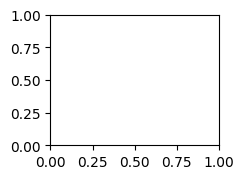

In [38]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./fgsm/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()